<a href="https://colab.research.google.com/github/george-kan/fastai/blob/main/Understanding_the_DataBlock_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai --upgrade

In [2]:
from fastai import *
from fastai.vision.all import *

The aim of this notebook is to deep dive into the DataBlock class of fastai in order to better understand its components.

###Let's start with a blank datablock.  

In [3]:
temp =  DataBlock()

In [4]:
temp.get_x, temp.get_items, temp.splitter, temp.get_y # All these methods are initialised to None by default

(None, None, None, None)

In [5]:
temp.blocks, temp.dl_type # By default it is assumed that both blocks (input and output) are generic TransformBlocks and the dl_type is a Transformed Dataloader (TfmdDL)

((fastai.data.block.TransformBlock, fastai.data.block.TransformBlock),
 fastai.data.core.TfmdDL)

In [6]:
temp._methods # All possible methods together in a list

['get_items', 'splitter', 'get_y', 'get_x']

### Variable initialisation inside the init function

In [7]:
temp.type_tfms 
#self.type_tfms = blocks.attrgot('type_tfms', L()) For both the input block and the output block we are initializing the type_tfms that are needed

(#2) [[],[]]

In [8]:
#self.default_item_tfms  = _merge_tfms(*blocks.attrgot('item_tfms',  L()))
temp.default_item_tfms  
# By default from the TransformBlock there is a ToTensor transformation in the itemblock

(#1) [ToTensor:
encodes: (PILMask,object) -> encodes
(PILBase,object) -> encodes
decodes: ]

In [9]:
#self.default_batch_tfms = _merge_tfms(*blocks.attrgot('batch_tfms', L()))
temp.default_batch_tfms

(#0) []

In [10]:
temp.dl_type

fastai.data.core.TfmdDL

In [11]:
inspect.signature(temp.dl_type.__init__)

<Signature (self, dataset, bs=64, shuffle=False, num_workers=None, verbose=False, do_setup=True, pin_memory=False, timeout=0, batch_size=None, drop_last=False, indexed=None, n=None, device=None, persistent_workers=False, *, wif=None, before_iter=None, after_item=None, before_batch=None, after_batch=None, after_iter=None, create_batches=None, create_item=None, create_batch=None, retain=None, get_idxs=None, sample=None, shuffle_fn=None, do_batch=None)>

In [12]:
#self.dataloaders = delegates(self.dl_type.__init__)(self.dataloaders)
temp.dataloaders
#self.dls_kwargs = merge(*blocks.attrgot('dls_kwargs', {}))
temp.dls_kwargs

{}

In [13]:
#self.n_inp = ifnone(n_inp, max(1, len(blocks)-1))
temp.n_inp
#self.getters = ifnone(getters, [noop]*len(self.type_tfms))
temp.getters

[<function fastai.imports.noop>, <function fastai.imports.noop>]

In [14]:
#if self.get_x:
#           if len(L(self.get_x)) != self.n_inp:
#               raise ValueError(f'get_x contains {len(L(self.get_x))} functions, but must contain {self.n_inp} (one for each input)\n{self._msg}')
#           self.getters[:self.n_inp] = L(self.get_x)
# The idea here is that the input blocks can be more than 1 but the output block has to be 1. Therefore the n_inp is initialized to be max(1, len(blocks) - 1) where the last -1 is the output block
temp.get_x, temp.get_y
#if self.get_y:
#    n_targs = len(self.getters) - self.n_inp
#    if len(L(self.get_y)) != n_targs:
#        raise ValueError(f'get_y contains {len(L(self.get_y))} functions, but must contain {n_targs} (one for each target)\n{self._msg}')
#    self.getters[self.n_inp:] = L(self.get_y)


(None, None)

### Using the datablock on an actual dataset
The very traditional MNIST (sample) dataset comes to our aid in order to see the DataBlock in practice

In [15]:
path = untar_data(URLs.MNIST_SAMPLE)
path.ls()
df = pd.read_csv('/root/.fastai/data/mnist_sample/labels.csv')

In [16]:
def get_y(r): return re.sub('.*/?(\\d)/.*', '\\1', r['name'])
def get_x(r): return path/r['name']
def splitter(r): return np.where(r['name'].str.startswith('train'))[0], np.where(r['name'].str.startswith('valid'))[0]
mnist = DataBlock(blocks = (ImageBlock, CategoryBlock),
                  get_x = get_x,
                  get_y = get_y,
                  splitter = splitter)
dls = mnist.dataloaders(df)

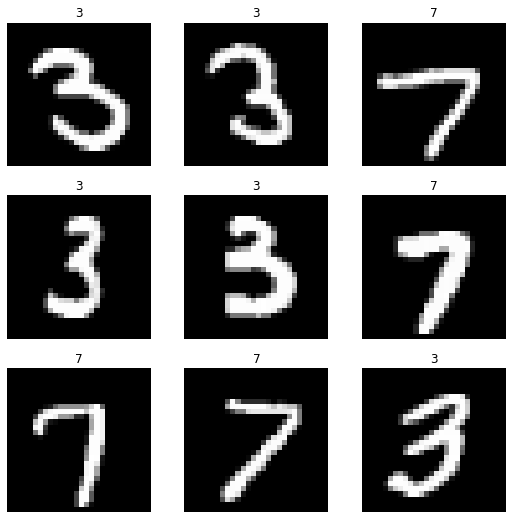

In [17]:
dls.show_batch()

In [18]:
mnist.blocks
# Clearly regardless of the actual block specifications the return value is a transformblock

(fastai.data.block.TransformBlock, fastai.data.block.TransformBlock)

In [19]:
mnist.type_tfms
# There are two type transforms here, the PILBase.create which comes from the ImageBlock and the Categorize which comes from the CategoryBlock

(#2) [[<bound method PILBase.create of <class 'fastai.vision.core.PILImage'>>],[Categorize -- {'vocab': None, 'sort': True, 'add_na': False}:
encodes: (object,object) -> encodes
decodes: (object,object) -> decodes
]]

In [20]:
mnist.type_tfms[0]
# def ImageBlock(cls=PILImage):
#    "A `TransformBlock` for images of `cls`"
#    return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor)

# The create method prepares the image to be passed to the load_image function depending on the input type (checked by the isinstance)
#class PILBase(Image.Image, metaclass=BypassNewMeta):
#    _bypass_type=Image.Image
#    _show_args = {'cmap':'viridis'}
#    _open_args = {'mode': 'RGB'}
#    @classmethod
#    def create(cls, fn:(Path,str,Tensor,ndarray,bytes), **kwargs)->None:
#        "Open an `Image` from path `fn`"
#        if isinstance(fn,TensorImage): fn = fn.permute(1,2,0).type(torch.uint8)
#        if isinstance(fn, TensorMask): fn = fn.type(torch.uint8)
#        if isinstance(fn,Tensor): fn = fn.numpy()
#        if isinstance(fn,ndarray): return cls(Image.fromarray(fn))
#        if isinstance(fn,bytes): fn = io.BytesIO(fn)
#        return cls(load_image(fn, **merge(cls._open_args, kwargs)))


# And the load image 
#def load_image(fn, mode=None):
#    "Open and load a `PIL.Image` and convert to `mode`"
#    im = Image.open(fn)
#    im.load()
#    im = im._new(im.im)
#    return im.convert(mode) if mode else im


(#1) [<bound method PILBase.create of <class 'fastai.vision.core.PILImage'>>]

In [21]:
mnist.type_tfms[1]
#def CategoryBlock(vocab=None, sort=True, add_na=False):
#    "`TransformBlock` for single-label categorical targets"
#    return TransformBlock(type_tfms=Categorize(vocab=vocab, sort=sort, add_na=add_na))

# The Categorize class initializes the loss function (to be used in the learner)
# Calls the CategoryMap in order to create the vocab
#class Categorize(DisplayedTransform):
#    "Reversible transform of category string to `vocab` id"
#    loss_func,order=CrossEntropyLossFlat(),1
#    def __init__(self, vocab=None, sort=True, add_na=False):
#        if vocab is not None: vocab = CategoryMap(vocab, sort=sort, add_na=add_na)
#        store_attr()

#    def setups(self, dsets):
#        if self.vocab is None and dsets is not None: self.vocab = CategoryMap(dsets, sort=self.sort, add_na=self.add_na)
#        self.c = len(self.vocab)

#    def encodes(self, o):
#        try:
#            return TensorCategory(self.vocab.o2i[o])
#        except KeyError as e:
#            raise KeyError(f"Label '{o}' was not included in the training dataset") from e
#    def decodes(self, o): return Category      (self.vocab    [o])

#Creates the vocabulary for our items by converting them to L (if the unique attribute is not available)
# The o2i (output to input) attribute has a dictionary for converting back the categories
#class CategoryMap(CollBase):
#    "Collection of categories with the reverse mapping in `o2i`"
#    def __init__(self, col, sort=True, add_na=False, strict=False):
#        if is_categorical_dtype(col):
#            items = L(col.cat.categories, use_list=True)
#            #Remove non-used categories while keeping order
#            if strict: items = L(o for o in items if o in col.unique())
#        else:
#            if not hasattr(col,'unique'): col = L(col, use_list=True)
#            # `o==o` is the generalized definition of non-NaN used by Pandas
#            items = L(o for o in col.unique() if o==o)
#            if sort: items = items.sorted()
#        self.items = '#na#' + items if add_na else items
#        self.o2i = defaultdict(int, self.items.val2idx()) if add_na else dict(self.items.val2idx())

#    def map_objs(self,objs):
#        "Map `objs` to IDs"
#        return L(self.o2i[o] for o in objs)

#    def map_ids(self,ids):
#        "Map `ids` to objects in vocab"
#        return L(self.items[o] for o in ids)

#    def __eq__(self,b): return all_equal(b,self)



(#1) [Categorize -- {'vocab': None, 'sort': True, 'add_na': False}:
encodes: (object,object) -> encodes
decodes: (object,object) -> decodes
]

In [24]:
mnist.item_tfms
# The ToTensor transformation comes by default from the TransformBlock

(#1) [ToTensor:
encodes: (PILMask,object) -> encodes
(PILBase,object) -> encodes
decodes: ]

In [25]:
mnist.batch_tfms
# The IntToFloatTensor comes from the ImageBlock

(#1) [IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes: (TensorImage,object) -> decodes
]

In [ ]:
#Here we see two type tfms:
# First is the PILBase.create of the ImageBlock which opens an image
# The second part is the Categorize of the CategoryBlock which creates vocabulary for the Categories in the Categoryblock
# By default the ImageBlock has a batch transformation IntToFloatTensor

In [ ]:
# Cell
@docs
@funcs_kwargs
class DataBlock():
    "Generic container to quickly build `Datasets` and `DataLoaders`"
    # These 4 lines are initializing the self parts
    get_x=get_items=splitter=get_y = None
    blocks,dl_type = (TransformBlock,TransformBlock),TfmdDL
    _methods = 'get_items splitter get_y get_x'.split()
    _msg = "If you wanted to compose several transforms in your getter don't forget to wrap them in a `Pipeline`."
    def __init__(self, blocks=None, dl_type=None, getters=None, n_inp=None, item_tfms=None, batch_tfms=None, **kwargs):
        blocks = L(self.blocks if blocks is None else blocks) #Either defaults or the blocks provided
        blocks = L(b() if callable(b) else b for b in blocks) #Functions (CategoryBlock) or someting else?
        self.type_tfms = blocks.attrgot('type_tfms', L()) 
        self.default_item_tfms  = _merge_tfms(*blocks.attrgot('item_tfms',  L()))
        self.default_batch_tfms = _merge_tfms(*blocks.attrgot('batch_tfms', L()))
        for b in blocks:
            if getattr(b, 'dl_type', None) is not None: self.dl_type = b.dl_type
        if dl_type is not None: self.dl_type = dl_type
        self.dataloaders = delegates(self.dl_type.__init__)(self.dataloaders)
        self.dls_kwargs = merge(*blocks.attrgot('dls_kwargs', {}))

        self.n_inp = ifnone(n_inp, max(1, len(blocks)-1))
        self.getters = ifnone(getters, [noop]*len(self.type_tfms))
        if self.get_x:
            if len(L(self.get_x)) != self.n_inp:
                raise ValueError(f'get_x contains {len(L(self.get_x))} functions, but must contain {self.n_inp} (one for each input)\n{self._msg}')
            self.getters[:self.n_inp] = L(self.get_x)
        if self.get_y:
            n_targs = len(self.getters) - self.n_inp
            if len(L(self.get_y)) != n_targs:
                raise ValueError(f'get_y contains {len(L(self.get_y))} functions, but must contain {n_targs} (one for each target)\n{self._msg}')
            self.getters[self.n_inp:] = L(self.get_y)

        if kwargs: raise TypeError(f'invalid keyword arguments: {", ".join(kwargs.keys())}')
        self.new(item_tfms, batch_tfms)

    def _combine_type_tfms(self): return L([self.getters, self.type_tfms]).map_zip(
        lambda g,tt: (g.fs if isinstance(g, Pipeline) else L(g)) + tt)

    def new(self, item_tfms=None, batch_tfms=None):
        self.item_tfms  = _merge_tfms(self.default_item_tfms,  item_tfms)
        self.batch_tfms = _merge_tfms(self.default_batch_tfms, batch_tfms)
        return self

    @classmethod
    def from_columns(cls, blocks=None, getters=None, get_items=None, **kwargs):
        if getters is None: getters = L(ItemGetter(i) for i in range(2 if blocks is None else len(L(blocks))))
        get_items = _zip if get_items is None else compose(get_items, _zip)
        return cls(blocks=blocks, getters=getters, get_items=get_items, **kwargs)

    def datasets(self, source, verbose=False):
        self.source = source                     ; pv(f"Collecting items from {source}", verbose)
        items = (self.get_items or noop)(source) ; pv(f"Found {len(items)} items", verbose)
        splits = (self.splitter or RandomSplitter())(items)
        pv(f"{len(splits)} datasets of sizes {','.join([str(len(s)) for s in splits])}", verbose)
        return Datasets(items, tfms=self._combine_type_tfms(), splits=splits, dl_type=self.dl_type, n_inp=self.n_inp, verbose=verbose)

    def dataloaders(self, source, path='.', verbose=False, **kwargs):
        dsets = self.datasets(source, verbose=verbose)
        kwargs = {**self.dls_kwargs, **kwargs, 'verbose': verbose}
        return dsets.dataloaders(path=path, after_item=self.item_tfms, after_batch=self.batch_tfms, **kwargs)

    _docs = dict(new="Create a new `DataBlock` with other `item_tfms` and `batch_tfms`",
                 datasets="Create a `Datasets` object from `source`",
                 dataloaders="Create a `DataLoaders` object from `source`")


In [ ]:
# Cell
class TransformBlock():
    "A basic wrapper that links defaults transforms for the data block API"
    def __init__(self, type_tfms=None, item_tfms=None, batch_tfms=None, dl_type=None, dls_kwargs=None):
        self.type_tfms  =            L(type_tfms)
        self.item_tfms  = ToTensor + L(item_tfms)
        self.batch_tfms =            L(batch_tfms)
        self.dl_type,self.dls_kwargs = dl_type,({} if dls_kwargs is None else dls_kwargs)

# Cell
def CategoryBlock(vocab=None, sort=True, add_na=False):
    "`TransformBlock` for single-label categorical targets"
    return TransformBlock(type_tfms=Categorize(vocab=vocab, sort=sort, add_na=add_na))

# Cell
def MultiCategoryBlock(encoded=False, vocab=None, add_na=False):
    "`TransformBlock` for multi-label categorical targets"
    tfm = EncodedMultiCategorize(vocab=vocab) if encoded else [MultiCategorize(vocab=vocab, add_na=add_na), OneHotEncode]
    return TransformBlock(type_tfms=tfm)

# Cell
def RegressionBlock(n_out=None):
    "`TransformBlock` for float targets"
    return TransformBlock(type_tfms=RegressionSetup(c=n_out))

# Cell
from inspect import isfunction,ismethod

# Cell
def _merge_grouper(o):
    if isinstance(o, LambdaType): return id(o)
    elif isinstance(o, type): return o
    elif (isfunction(o) or ismethod(o)): return o.__qualname__
    return o.__class__

# Cell
def _merge_tfms(*tfms):
    "Group the `tfms` in a single list, removing duplicates (from the same class) and instantiating"
    g = groupby(concat(*tfms), _merge_grouper)
    return L(v[-1] for k,v in g.items()).map(instantiate)

def _zip(x): return L(x).zip()


# Cell
def _short_repr(x):
    if isinstance(x, tuple): return f'({", ".join([_short_repr(y) for y in x])})'
    if isinstance(x, list): return f'[{", ".join([_short_repr(y) for y in x])}]'
    if not isinstance(x, Tensor): return str(x)
    if x.numel() <= 20 and x.ndim <=1: return str(x)
    return f'{x.__class__.__name__} of size {"x".join([str(d) for d in x.shape])}'

# Cell
def _apply_pipeline(p, x):
    print(f"  {p}\n    starting from\n      {_short_repr(x)}")
    for f in p.fs:
        name = f.name
        try:
            x = f(x)
            if name != "noop": print(f"    applying {name} gives\n      {_short_repr(x)}")
        except Exception as e:
            print(f"    applying {name} failed.")
            raise e
    return x

# Cell
from .load import _collate_types

def _find_fail_collate(s):
    s = L(*s)
    for x in s[0]:
        if not isinstance(x, _collate_types): return f"{type(x).__name__} is not collatable"
    for i in range_of(s[0]):
        try: _ = default_collate(s.itemgot(i))
        except:
            shapes = [getattr(o[i], 'shape', None) for o in s]
            return f"Could not collate the {i}-th members of your tuples because got the following shapes\n{','.join([str(s) for s in shapes])}"

# Cell
@patch
def summary(self: DataBlock, source, bs=4, show_batch=False, **kwargs):
    "Steps through the transform pipeline for one batch, and optionally calls `show_batch(**kwargs)` on the transient `Dataloaders`."
    print(f"Setting-up type transforms pipelines")
    dsets = self.datasets(source, verbose=True)
    print("\nBuilding one sample")
    for tl in dsets.train.tls:
        _apply_pipeline(tl.tfms, get_first(dsets.train.items))
    print(f"\nFinal sample: {dsets.train[0]}\n\n")

    dls = self.dataloaders(source, bs=bs, verbose=True)
    print("\nBuilding one batch")
    if len([f for f in dls.train.after_item.fs if f.name != 'noop'])!=0:
        print("Applying item_tfms to the first sample:")
        s = [_apply_pipeline(dls.train.after_item, dsets.train[0])]
        print(f"\nAdding the next {bs-1} samples")
        s += [dls.train.after_item(dsets.train[i]) for i in range(1, bs)]
    else:
        print("No item_tfms to apply")
        s = [dls.train.after_item(dsets.train[i]) for i in range(bs)]

    if len([f for f in dls.train.before_batch.fs if f.name != 'noop'])!=0:
        print("\nApplying before_batch to the list of samples")
        s = _apply_pipeline(dls.train.before_batch, s)
    else: print("\nNo before_batch transform to apply")

    print("\nCollating items in a batch")
    try:
        b = dls.train.create_batch(s)
        b = retain_types(b, s[0] if is_listy(s) else s)
    except Exception as e:
        print("Error! It's not possible to collate your items in a batch")
        why = _find_fail_collate(s)
        print("Make sure all parts of your samples are tensors of the same size" if why is None else why)
        raise e

    if len([f for f in dls.train.after_batch.fs if f.name != 'noop'])!=0:
        print("\nApplying batch_tfms to the batch built")
        b = to_device(b, dls.device)
        b = _apply_pipeline(dls.train.after_batch, b)
    else: print("\nNo batch_tfms to apply")

    if show_batch: dls.show_batch(**kwargs)